# Correlation among parcels to see CAP

In [1]:
import os 
import pandas as pd
import glob
import numpy as np
import json
import nibabel as nib
import nilearn.plotting
import nilearn.image
from nipype.interfaces.base import Bunch
import csv
import shutil
import math, re

%matplotlib inline
import matplotlib.pyplot as plt

from nilearn.input_data import NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting

/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


240210-17:38:16,868 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.7.0


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
from nilearn import datasets

atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename1 = atlas["maps"]
# Loading atlas data stored in 'labels'
labels1 = atlas["labels"]

# dataset1 = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm", symmetric_split = True)

# atlas_filename1 = dataset1.maps
# labels1 = dataset1.labels

dataset2 = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm", symmetric_split = True)

atlas_filename2 = dataset2.maps
labels2 = dataset2.labels

all_labels = labels1+labels2[1:]

In [18]:
parcellation = atlas['maps']

In [3]:
from nilearn.maskers import NiftiMapsMasker, NiftiLabelsMasker

masker1 = NiftiMapsMasker(
    maps_img=atlas_filename1,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

# masker1 = NiftiLabelsMasker(
#     labels_img=atlas_filename1,
#     standardize="zscore_sample",
#     standardize_confounds="zscore_sample",
#     memory="nilearn_cache",
#     verbose=5,
# )

masker2 = NiftiLabelsMasker(
    labels_img=atlas_filename2,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

In [4]:
# set paths for directories
home_path = os.path.expanduser('~')
project_path = os.path.join(home_path,'Desktop','resting')
data_path = os.path.join(project_path,'data')
fmriprep_path = os.path.join(project_path,'data','derivatives')

In [5]:
subj_set_ = []
task_set_ = []
data_set_ = []

subj_set = ['cjy','ksy','psy','hsj','jmj','kms','lhs']
task_set = ['pre','post']

for this_subj in subj_set:
    for this_task in task_set:
    
    
        filename1 = os.path.join(fmriprep_path,'sub-%s' %(this_subj),'func',
                             'sub-%s_task-%s_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz' %(this_subj, this_task))
        print(filename1)
        
        # create reduced confound
        original_confound1 = pd.read_csv(os.path.join(fmriprep_path,'sub-%s' %(this_subj),'func',
                                        'sub-%s_task-%s_run-1_desc-confounds_timeseries.tsv' %(this_subj, this_task)), sep='\t')
        
        selected_columns = ['global_signal','csf','white_matter','tcompcor','dvars','framewise_displacement',
                            'a_comp_cor_00','a_comp_cor_01','a_comp_cor_02',
                            'trans_x','trans_y','trans_z',
                            'rot_x','rot_y','rot_z']
        
        new_confound1 = original_confound1[selected_columns]
        new_confound1 = new_confound1.fillna(0)
        
        in_confound = 'sub-%s_task-%s_run-1_desc-reducedconfounds_timeseries.tsv' %(this_subj, this_task)
        new_confound1.to_csv(in_confound, sep='\t', index=False)
        print(in_confound)
        
        cort_time_series = masker1.fit_transform(filename1, confounds = in_confound)
        subc_time_series = masker2.fit_transform(filename1, confounds = in_confound)
        
        both_series = np.hstack((cort_time_series,subc_time_series))
                
        filt_both_series_run = nilearn.signal.clean(both_series, runs=None, detrend=True, standardize='zscore',
                                                    sample_mask=None, confounds=None, standardize_confounds=None,
                                                    filter='butterworth', low_pass=1/64, high_pass=None, t_r=3)
        
        subj_set_.append(this_subj)
        task_set_.append(this_task)
        data_set_.append(both_series)

/Users/nova/Desktop/resting/data/derivatives/sub-cjy/func/sub-cjy_task-pre_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-cjy_task-pre_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
[Memory]0.0s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:244: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  "memory_level is currently set to 0 but "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]0.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-cjy/func/sub-cjy_task-post_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-cjy_task-post_run-1_desc-reducedconfounds_timeseries.tsv


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/Users/nova/Desktop/resting/data/derivatives/sub-cjy/func/sub-cjy_task-post_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz', 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x7fbd9126cb50>, { 'allow_overlap': True,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'maps_img': '/Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': 'zscore_sample',
  'standardize_confounds': 'zscore_sample',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=['sub-cjy_task-post_run-1_desc-reducedconfounds_

/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]8.9s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]8.6s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-ksy/func/sub-ksy_task-post_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-ksy_task-post_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]10.8s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]10.5s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-psy/func/sub-psy_task-pre_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-psy_task-pre_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]12.7s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]12.4s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-psy/func/sub-psy_task-post_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-psy_task-post_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]14.6s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]14.3s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-hsj/func/sub-hsj_task-pre_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-hsj_task-pre_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]16.4s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]16.1s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-hsj/func/sub-hsj_task-post_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-hsj_task-post_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]18.2s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]17.9s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-jmj/func/sub-jmj_task-pre_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-jmj_task-pre_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]20.1s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]19.9s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-jmj/func/sub-jmj_task-post_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-jmj_task-post_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]22.1s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]21.8s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-kms/func/sub-kms_task-pre_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-kms_task-pre_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]24.0s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]23.7s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-kms/func/sub-kms_task-post_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-kms_task-post_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]25.9s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]25.6s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-lhs/func/sub-lhs_task-pre_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-lhs_task-pre_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]27.8s, 0.5min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]27.5s, 0.5min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
/Users/nova/Desktop/resting/data/derivatives/sub-lhs/func/sub-lhs_task-post_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz
sub-lhs_task-post_run-1_desc-reducedconfounds_timeseries.tsv
[NiftiMapsMasker.fit_transform] loading regions from /Users/nova/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


[Memory]29.7s, 0.5min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]29.4s, 0.5min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.


In [6]:
correlation_measure = ConnectivityMeasure(
    kind="correlation",
    # standardize="zscore_sample",
)

In [7]:
task_set_

['pre',
 'post',
 'pre',
 'post',
 'pre',
 'post',
 'pre',
 'post',
 'pre',
 'post',
 'pre',
 'post',
 'pre',
 'post']

/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/nilearn/connectome/connectivity_matrices.py:499: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  for x in X
/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/nilearn/connectome/connectivity_matrices.py:499: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  for x in X
/opt/miniconda3/

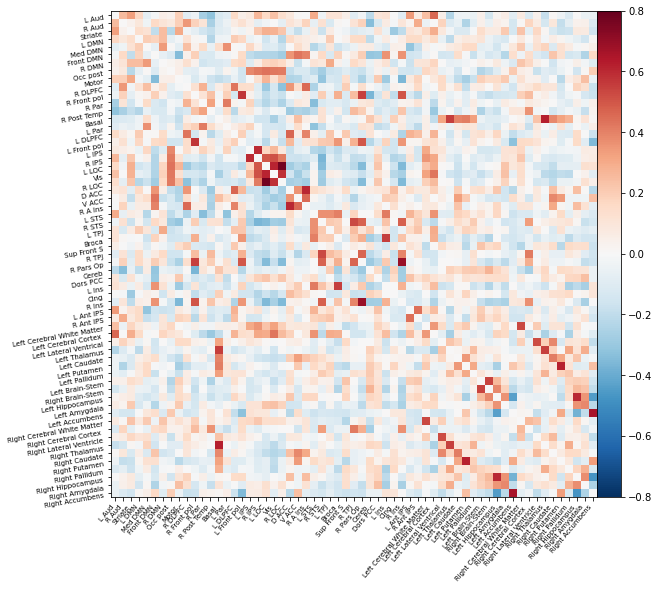

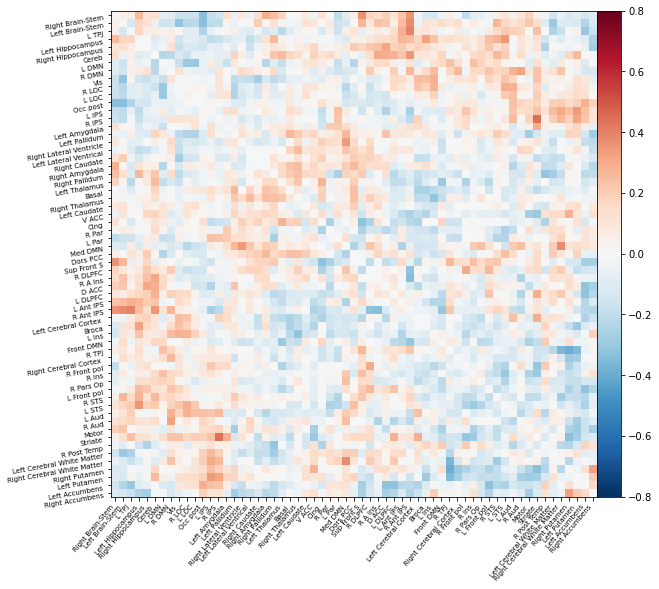

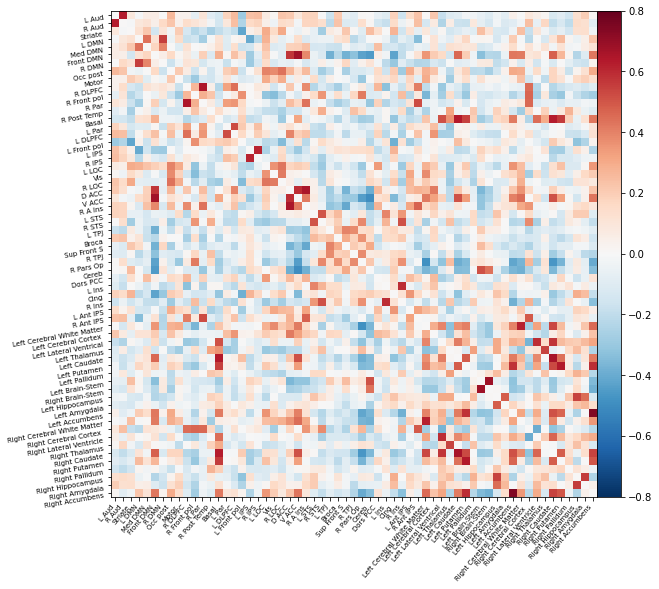

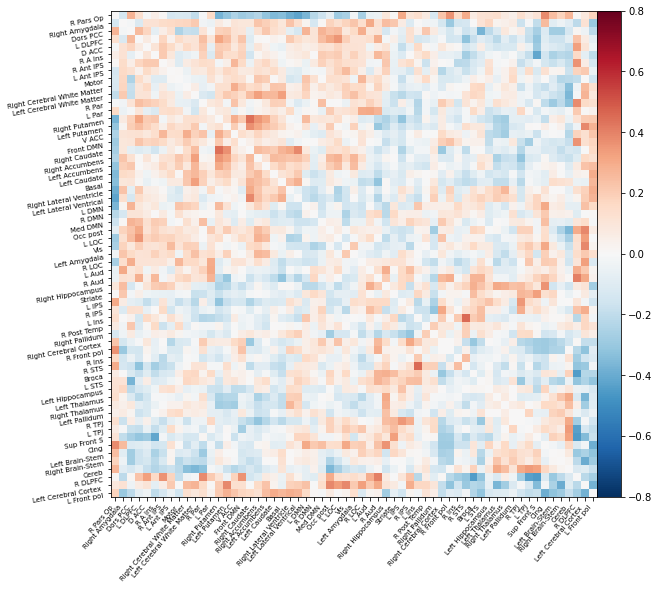

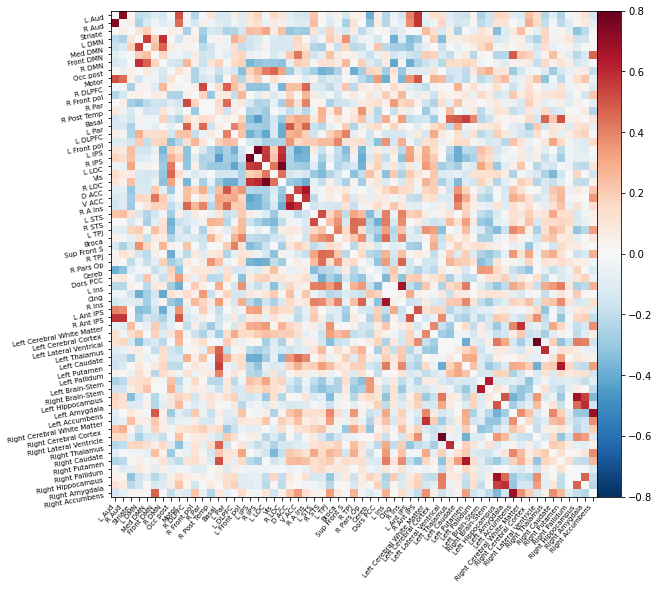

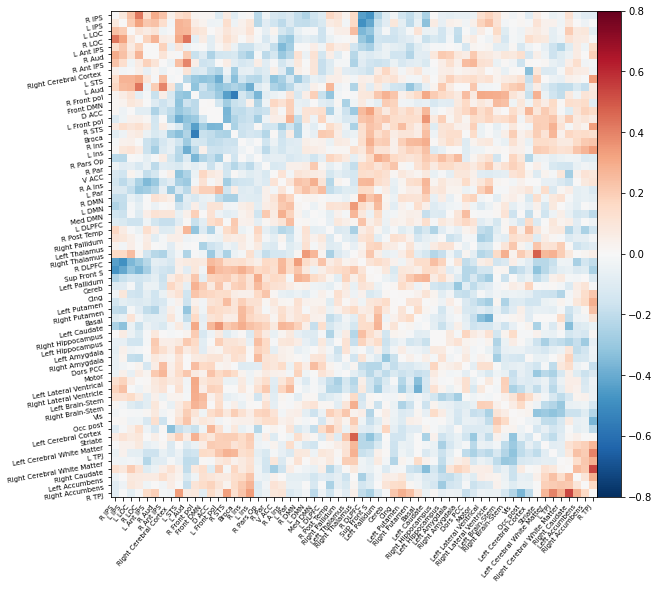

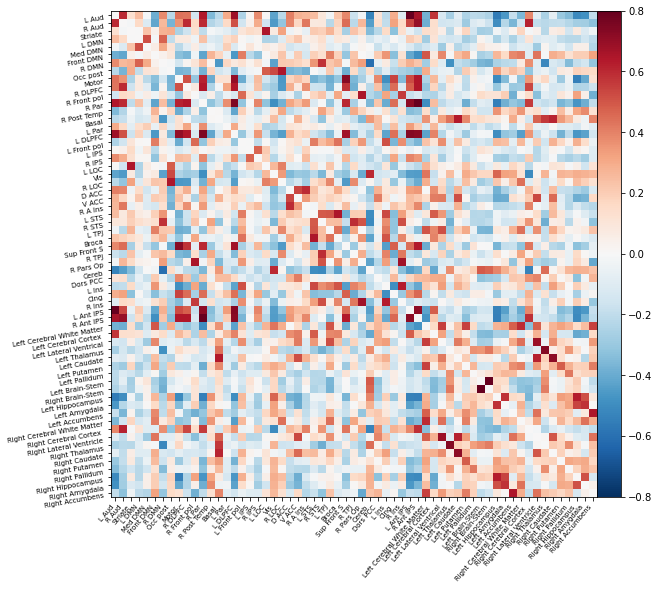

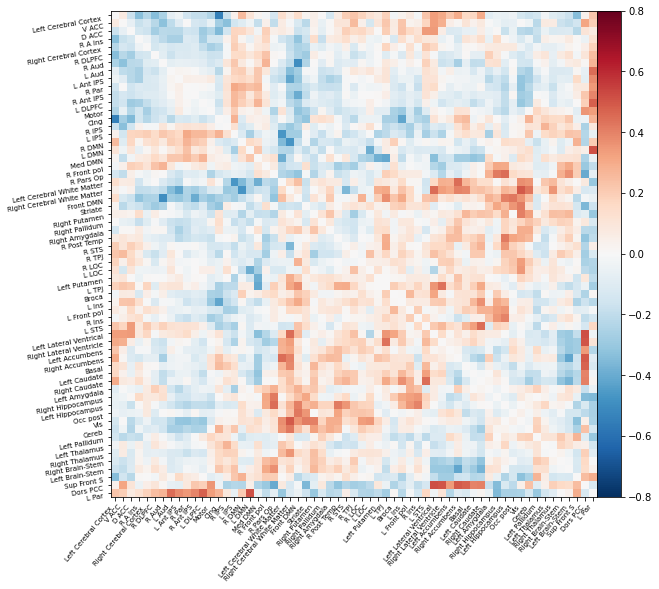

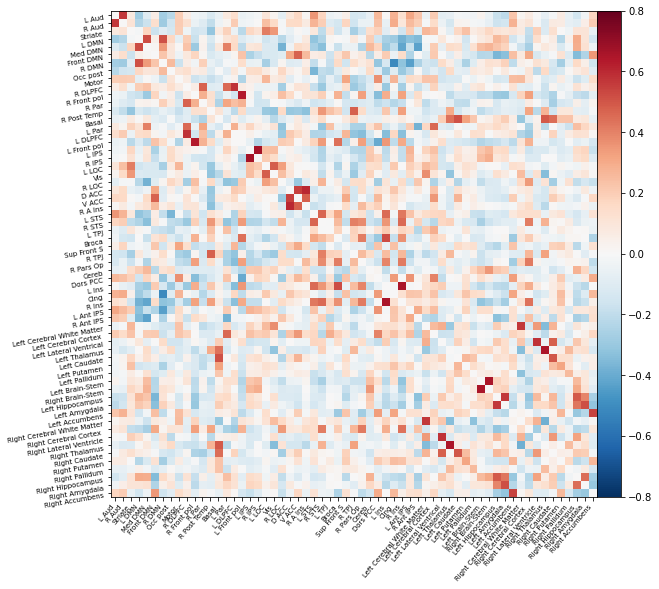

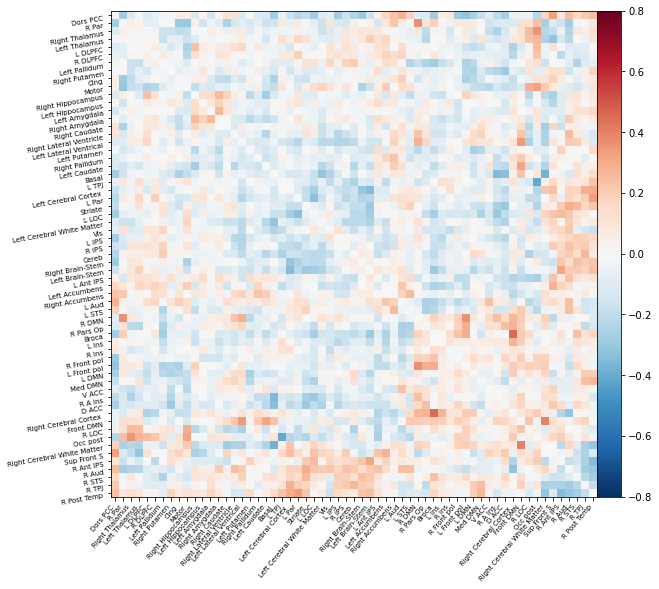

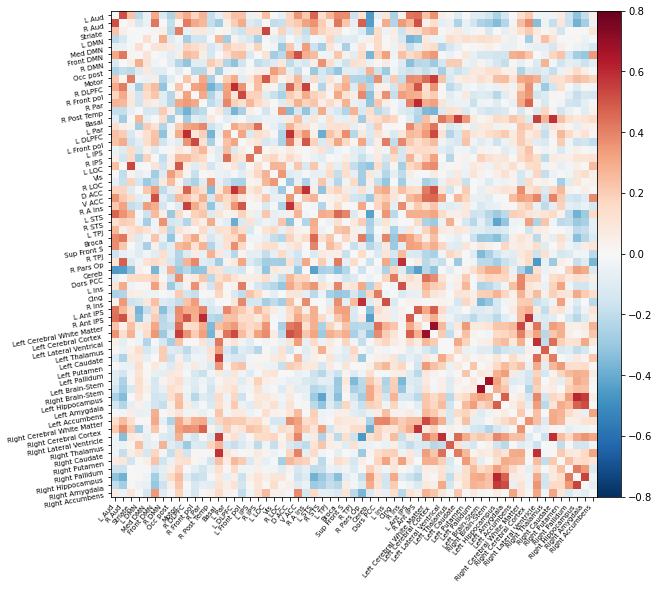

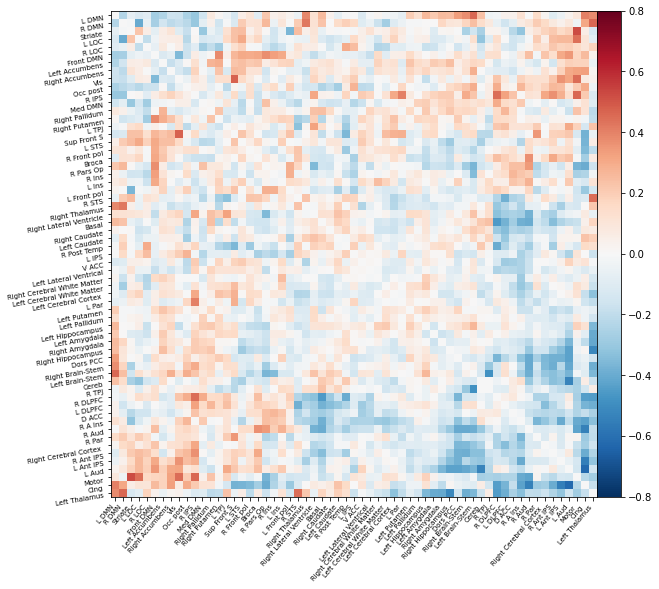

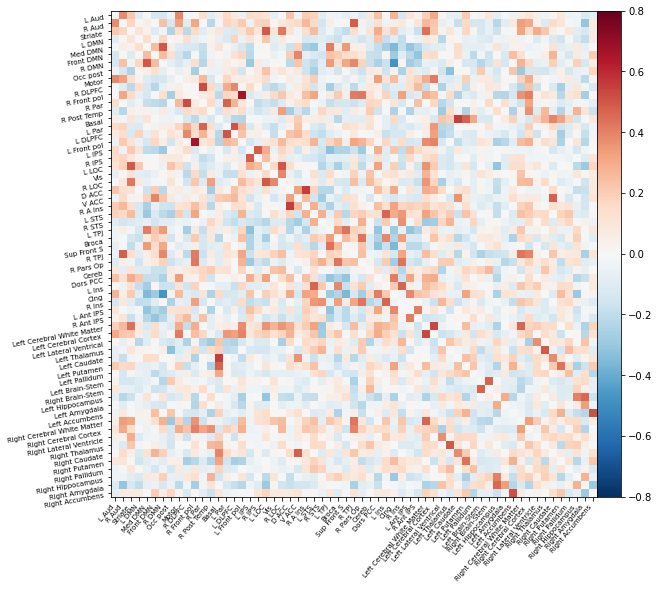

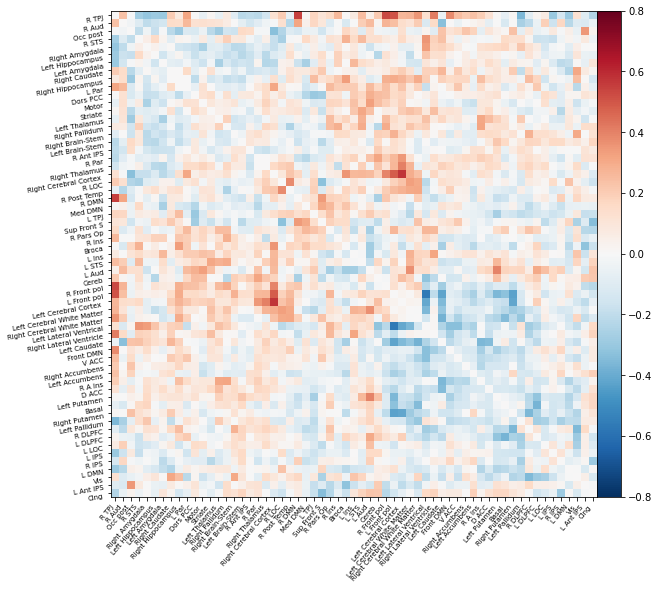

In [8]:
for this_index, this_set in enumerate(task_set_): 
    
    if np.mod(this_index,2) == 0:
        this_data = data_set_[this_index]
        correlation_matrix_run = correlation_measure.fit_transform([this_data])[0]
    else:
        this_data1 = data_set_[this_index]
        correlation_matrix_run1 = correlation_measure.fit_transform([this_data1])[0]
        
        this_data2 = data_set_[this_index-1]
        correlation_matrix_run2 = correlation_measure.fit_transform([this_data2])[0]
        
        correlation_matrix_run = correlation_matrix_run2 - correlation_matrix_run1
        
    
    if np.mod(this_index,2) == 0:
        # Plot the correlation matrix
        np.fill_diagonal(correlation_matrix_run, 0)
        plotting.plot_matrix(
            correlation_matrix_run,
            figure=(10, 8),
            labels= all_labels,
            vmax=0.8,
            vmin=-0.8,
            reorder=False,
        )
    else:
        # Plot the correlation matrix
        np.fill_diagonal(correlation_matrix_run, 0)
        plotting.plot_matrix(
            correlation_matrix_run,
            figure=(10, 8),
            labels= all_labels,
            vmax=0.8,
            vmin=-0.8,
            reorder=True,
        )

In [9]:
correlation_matrix_run.shape

(61, 61)

In [10]:
all_matrix_pre = np.full((61,61,7),0.0)
all_matrix_dif = np.full((61,61,7),0.0)

In [11]:
for this_index, this_set in enumerate(task_set_): 
    
    if np.mod(this_index,2) == 0:
        this_data = data_set_[this_index]
        all_matrix_pre[:,:,int(this_index/2)] = correlation_measure.fit_transform([this_data])[0]
    else:
        this_data1 = data_set_[this_index]
        correlation_matrix_run1 = correlation_measure.fit_transform([this_data1])[0]
        
        this_data2 = data_set_[this_index-1]
        correlation_matrix_run2 = correlation_measure.fit_transform([this_data2])[0]

        all_matrix_dif[:,:,int(this_index/2)] = correlation_matrix_run2 - correlation_matrix_run1

/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/nilearn/connectome/connectivity_matrices.py:499: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  for x in X
/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/nilearn/connectome/connectivity_matrices.py:499: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  for x in X
/opt/miniconda3/

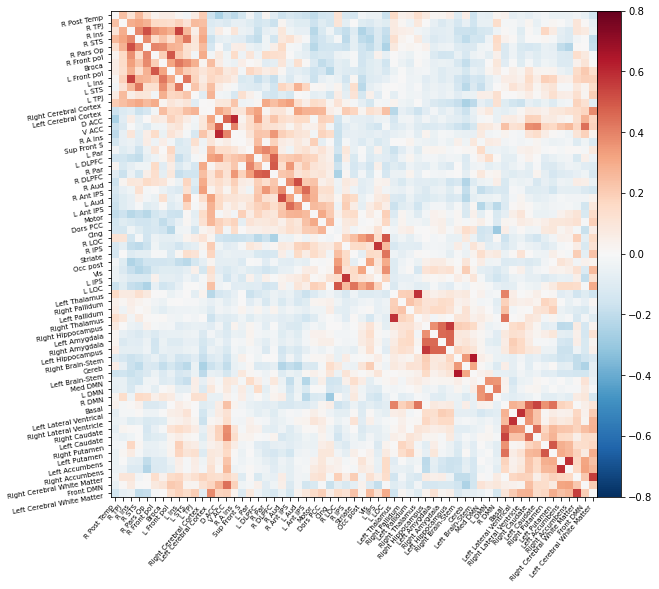

In [15]:
output_matrix = np.mean(all_matrix_pre,axis=2)
np.fill_diagonal(output_matrix, 0)
plotting.plot_matrix(
    output_matrix,
    figure=(10, 8),
    labels= all_labels,
    vmax=0.8,
    vmin=-0.8,
    reorder=True,
)

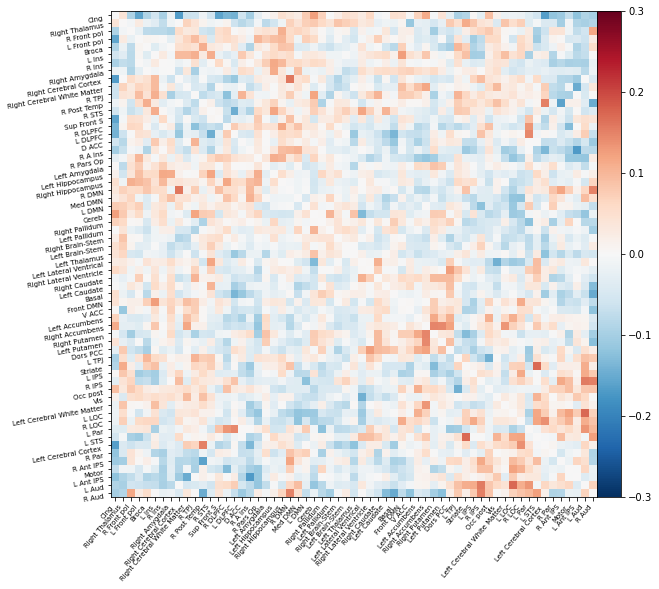

In [14]:
output_matrix = np.mean(all_matrix_dif,axis=2)
np.fill_diagonal(output_matrix, 0)
plotting.plot_matrix(
    output_matrix,
    figure=(10, 8),
    labels= all_labels,
    vmax=0.3,
    vmin=-0.3,
    reorder=True,
)

In [16]:
plotting.plot_surf_roi(surface_mesh='fsaverage', roi_map=parcellation, hemi='left',
                       view='lateral', bg_map='fsaverage', bg_on_data=True,
                       darkness=0.5, title='Brain Parcels')

# Plot correlation matrix as heatmap
plt.figure()
plt.imshow(all_matrix_dif, cmap='hot', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')
plt.show()

NameError: name 'parcellation' is not defined